In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Nx, Ny = 32, 32
dt, tfinal = 0.001, 1.5
n_timesteps = int(np.floor(tfinal/dt))

dx = 2*np.pi/Nx
dy = 2*np.pi/Ny

xx = np.arange(0, Nx)*dx
yy = np.arange(0, Ny)*dy

kx = np.ones((1, Ny)).T * (np.arange(-Nx/2, Nx/2))
ky = np.reshape(np.arange(-Ny/2, Ny/2), (1, Ny)).T * np.ones((1, Nx))

k2 = kx**2+ky**2
k2[int(Nx/2),int(Nx/2)]=1

dealias = (np.abs(kx) < (2.0/3.0)*(Nx/2.0)) * (np.abs(ky)<(2.0/3.0)*(Ny/2.0))

In [3]:
X, Y = np.meshgrid(xx, yy)
w = -np.sin(X) - np.cos(X)*np.cos(Y)
g = np.sin(X)*np.sin(Y) - np.cos(Y)

w_hat = np.fft.fftshift(np.fft.fft2(w))
g_hat = np.fft.fftshift(np.fft.fft2(g))

g_norm = np.zeros(n_timesteps)

for iteration_time in range(0, n_timesteps):
    if np.mod(iteration_time, 10)==0:
        seconds = np.round(iteration_time*dt,4)
        print(f"Time: {seconds}s")
        #plt.imshow(w.T, cmap='hot')
        #plt.pcolormesh(xx, yy, w.T, cmap='hot')
        #if iteration_time==0:
        #    plt.colorbar()          
        #plt.title("2D Euler")
        #plt.show(False)
        #plt.savefig("Euler_images/vorticity_{0}".format(int(iteration_time/10)))
    
    u_hat = 1j*(np.multiply(kx,g_hat)+np.multiply(ky,w_hat))/k2
    v_hat = 1j*(np.multiply(ky,g_hat)-np.multiply(kx,w_hat))/k2
    
    u_hat[int(Ny/2),int(Nx/2)]=0
    v_hat[int(Ny/2),int(Nx/2)]=0
    
    u = np.real(np.fft.ifft2(np.fft.ifftshift(u_hat)))
    v = np.real(np.fft.ifft2(np.fft.ifftshift(v_hat)))
    
    avg_g2 = 1/(2*np.pi)**2 * (np.sum(g**2))*dx*dy
    
    wx = np.real(np.fft.ifft2(np.fft.ifftshift(1j*np.multiply(kx,w_hat))))
    wy = np.real(np.fft.ifft2(np.fft.ifftshift(1j*np.multiply(ky,w_hat))))
    gx = np.real(np.fft.ifft2(np.fft.ifftshift(1j*np.multiply(kx,g_hat))))
    gy = np.real(np.fft.ifft2(np.fft.ifftshift(1j*np.multiply(ky,g_hat))))
    
    w = dt*(np.multiply(g,w) - np.multiply(u,wx)-np.multiply(v,wy)) + w
    g = dt*(2*avg_g2 - np.power(g,2) - np.multiply(u,gx)-np.multiply(v,gy)) + g
    
    w_hat = np.multiply(np.fft.fftshift(np.fft.fft2(w)),dealias)
    g_hat = np.multiply(np.fft.fftshift(np.fft.fft2(g)),dealias)
    
    g_norm[iteration_time] = np.max(np.sum(np.abs(g), axis=1))
    
    if g_norm[iteration_time]>2**32-1:
        seconds = iteration_time * dt
        print(f"Solution has blown up at T* = {seconds}")
        break

Time: 0.0s
Time: 0.001s
Time: 0.002s
Time: 0.003s
Time: 0.004s
Time: 0.005s
Time: 0.006s
Time: 0.007s
Time: 0.008s
Time: 0.009s
Time: 0.01s
Time: 0.011s
Time: 0.012s
Time: 0.013s
Time: 0.014s
Time: 0.015s
Time: 0.016s
Time: 0.017s
Time: 0.018s
Time: 0.019s
Time: 0.02s
Time: 0.021s
Time: 0.022s
Time: 0.023s
Time: 0.024s
Time: 0.025s
Time: 0.026s
Time: 0.027s
Time: 0.028s
Time: 0.029s
Time: 0.03s
Time: 0.031s
Time: 0.032s
Time: 0.033s
Time: 0.034s
Time: 0.035s
Time: 0.036s


KeyboardInterrupt: 

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def update_vorticity(g, w, lam, u, v, dt, dx, dy, kx, ky):
    # Add the +g and +w for forward euler, then call this func instead of 
    # vorticity_rk4 for faster computation
    gnew = dt*((2+lam)*g2_avg(g, dx, dy)- (1+lam)*g**2 - convect(g, u, v, kx, ky)) #+g
    wnew = dt*(g*w - convect(w, u, v, kx, ky)) #+w
    return gnew, wnew

def vorticity_rk4(g, w, lam, u, v, dt, dx, dy, kx, ky):
    kg1, kw1 = update_vorticity(g,w, lam, u,v,dt,dx,dy,kx,ky)
    kg2, kw2 = update_vorticity(g+kg1/2,w+kw1/2, lam, u,v,dt,dx,dy,kx,ky)
    kg3, kw3 = update_vorticity(g+kg2/2,w+kw2/2, lam, u,v,dt,dx,dy,kx,ky)
    kg4, kw4 = update_vorticity(g+kg3,w+kw3, lam, u,v,dt,dx,dy,kx,ky)

    g_new = g + 1/6*(kg1+2.*kg2+2.*kg3+kg4)    
    w_new = w + 1/6*(kw1+2*kw2+2*kw3+kw4)

    return g_new, w_new

def update_velocities(g_hat, w_hat, kx, ky, k2):

    uhat = 1j*(kx*g_hat+ky*w_hat)/(k2)
    vhat = 1j*(ky*g_hat-kx*w_hat)/(k2)
    # Assume no zero mode
    Ny, Nx = np.shape(k2)
    uhat[int(Ny/2),int(Nx/2)]=0
    vhat[int(Ny/2),int(Nx/2)]=0

    u = np.real(np.fft.ifft2(np.fft.ifftshift(uhat)))
    v = np.real(np.fft.ifft2(np.fft.ifftshift(vhat)))

    return u, v

def g2_avg(g, dx, dy):
    avg = 1.0/(2*np.pi)**2 * np.sum(g**2)*dx*dy
    return avg

def convect(C, u, v, kx, ky):
    C_hat = np.fft.fftshift(np.fft.fft2(C))
    C_x = np.real(np.fft.ifft2(np.fft.ifftshift(1j*kx*C_hat)))
    C_y = np.real(np.fft.ifft2(np.fft.ifftshift(1j*ky*C_hat)))
    convec_term = (u*C_x + v*C_y)

    return convec_term

def initial_conditions(xx, yy):
    X, Y = np.meshgrid(xx, yy)
    w0 = -np.sin(X) - np.cos(X)*np.cos(Y)
    g0 = np.sin(X)*np.sin(Y) - np.cos(Y)
    #w0 = np.sin(X)*np.sin(Y)
    #g0 = np.sin(X)*np.sin(Y)

    return w0, g0

def blowup_test(g):
    # infinity norm
    norm_g = np.max(np.sum(np.abs(g), axis=1))
    if norm_g >= 2**32 -1:
        blowup = True
    else:
        blowup = False
    return blowup

def res(f, g):
    Q = np.abs(f-g)/(np.abs(f)+np.abs(g))
    return Q


def euler_solve(N=256, dt=0.001, tfinal=2, lam=-3.0/2):

    # Grid specifications
    Nx, Ny = N, N
    #dt, tfinal = 0.001, 2
    #lam = -3.0/2
    n_timesteps = int(np.floor(tfinal/dt))
    print("~~ Euler Vorticity Solver ~~ \n")
    print(f"##### \nParameters: \nGrid points = {Nx}x{Ny}")
    print(f"final time = {tfinal}s")
    # Grid spacing
    dx = 2.*np.pi/Nx
    dy = 2.*np.pi/Ny

    # Discretized grid
    xx = np.arange(0, Nx)*dx
    yy = np.arange(0, Ny)*dy
    print("Setting intial conditions... \n")
    w, g  = initial_conditions(xx, yy)
    w_hat = np.fft.fftshift(np.fft.fft2(w))
    g_hat = np.fft.fftshift(np.fft.fft2(g))

    # Matrices of wavesnumbers
    kx = np.ones((1, Ny)).T * (np.arange(-Nx/2, Nx/2))
    ky = np.reshape(np.arange(-Ny/2, Ny/2), (1, Ny)).T * np.ones((1, Nx))

    k2 = kx**2+ky**2
    k2[int(Nx/2),int(Nx/2)]=1

    dealias = (np.abs(kx) < (2.0/3.0)*(Nx/2.0)) * (np.abs(ky)<(2.0/3.0)*(Ny/2.0))

    res = np.zeros(n_timesteps)
    print("Entering time loop... \n")
    # Update the vorticity and stretching terms in each timestep
    for iteration_time in range(0, n_timesteps):
        if np.mod(iteration_time, 100)==0:
            seconds = np.round(iteration_time*dt,4)
            print(f"Time: {seconds}s")
            #plt.pcolormesh(yy, xx, w.T, cmap="hot")
            #plt.colorbar()
            #plt.clim(vmin=-2, vmax=2)
            #plt.title("2D Euler - Vorticity")
            #plt.pause(1e-8)
            #plt.clf()
            # Implement numerical consistancy checks...

        g_old = np.copy(g)
        u, v = update_velocities(g_hat, w_hat, kx, ky, k2)
        g, w = vorticity_rk4(g, w, lam, u, v, dt, dx, dy, kx, ky)
        blowup = blowup_test(g)
        if blowup:
            seconds = iteration_time*dt
            print(f"Solution has blownup at T* = {seconds} \n")
            print("Exiting loop.")
            #plt.pcolormesh(yy, xx, w.T, cmap='hot')
            #plt.title("2D Euler - Vorticity")
            #plt.colorbar()
            #plt.show()
            break
        # dealias
        w_hat = np.fft.fftshift(np.fft.fft2(w))*dealias
        g_hat = np.fft.fftshift(np.fft.fft2(g))*dealias
 

    #print("Simulation finished. \n Showing final plot... \n")
    #plt.pcolormesh(yy, xx, w, cmap="hot")
    #plt.title("2D Euler - Vorticity")
    #plt.colorbar()
    #plt.clim(vmin=-2, vmax=2)
    #plt.show()

    return g



In [244]:

dt = 0.001
tfinal = 1.0
lam = 0
#g_8  = euler_solve(N=8, dt=dt, tfinal=tfinal, lam=lam)
#g_16 = euler_solve(N=16, dt = dt, tfinal=tfinal, lam=lam)
#g_32 =  euler_solve(N=32, dt=dt, tfinal=tfinal, lam=lam)
#g_64 =  euler_solve(N=64, dt=dt, tfinal=tfinal, lam=lam)
#g_128 = euler_solve(N=128, dt=dt, tfinal=tfinal, lam=lam)
#g_256 = euler_solve(N=256, dt=dt, tfinal=tfinal, lam=lam)
#g_512 = euler_solve(N=512, dt=dt, tfinal=tfinal, lam=lam)
#g_1024 = euler_solve(N=1024, dt=dt, tfinal=tfinal, lam=lam)

g16_g8  = np.sum(np.abs( g_16[::2, ::2] - g_8))*(2*np.pi/8)**2
g32_g16 = np.sum(np.abs( g_32[::2, ::2] - g_16))*(2*np.pi/16)**2
g64_g32 = np.sum(np.abs( g_64[::2, ::2] - g_32 ))*(2*np.pi/32)**2
g128_g64 = np.sum(np.abs( g_128[::2, ::2] - g_64 ))*(2*np.pi/64)**2
g256_g128 = np.sum(np.abs( g_256[::2, ::2] - g_128 ))*(2*np.pi/128)**2
g512_g256 = np.sum(np.abs( g_512[::2, ::2] - g_256 ))*(2*np.pi/256)**2
g1024_g512 = np.sum(np.abs( g_1024[::2, ::2] - g_512))*(2*np.pi/512)**2

/home/ryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


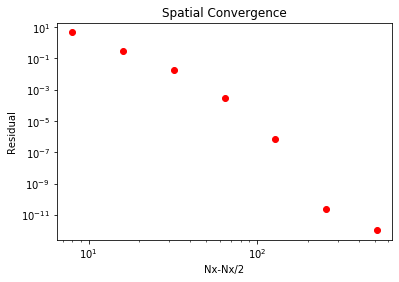

In [245]:

plt.close()
deltaX = np.array([8, 16, 32, 64, 128, 256, 512])
res = np.array([g16_g8, g32_g16, g64_g32, g128_g64, g256_g128, g512_g256, g1024_g512])

# fit the curve
def f(x, a, b, c, d):
    return a*np.log(b*x)+c

popt, pcov = curve_fit(f, deltaX, res)


plt.loglog(deltaX, res, 'ro')
plt.title('Spatial Convergence')
plt.xlabel('Nx-Nx/2')
plt.ylabel('Residual')

locs, lables = plt.yticks()

plt.show()

In [246]:
x = np.log(deltaX)
y = np.log(res)

In [247]:
def f(x, a, b):
    return a*x + b

In [248]:
popt, pcov = curve_fit(f, x, y)

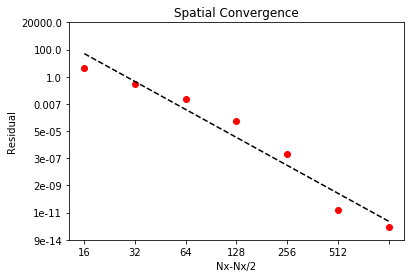

In [251]:
plt.plot(x, y, 'ro')
plt.plot(x, f(x, *popt), 'k--')
locs2, l2 = plt.yticks()
plt.xticks(x, [16, 32, 64, 128, 256, 512])
lo = np.copy(locs2)
for i in range(len(lo)):
    lo[i] = np.format_float_scientific(np.exp(locs2[i]), precision=0)
plt.yticks(locs2, lo)
plt.xlabel('Nx-Nx/2')
plt.ylabel('Residual')
plt.title('Spatial Convergence')
plt.savefig('spatial_convergence')
plt.show()